## **Effects of alcohol on student performance**
### Data Analytics
### Automatic Control and Robotics, Cyber-physical Systems
#### **Daniel Jurkowski (407200) & Adam Pękala (405380)**



#### Modules import

In [24]:
from cmdstanpy import CmdStanModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import arviz as az
import seaborn as sns
import cmdstanpy

#### CmdStanPy installation

In [25]:
cmdstanpy.install_cmdstan()

CmdStan install directory: /home/daniel/.cmdstan
CmdStan version 2.35.0 already installed
Test model compilation


True

## 1. Problem formulation - statement, point of creating model and data origin.

Alcohol use among students is a topic of interest due to its potential impact on educational outcomes. This project aims to explore the relationship between alcohol consumption and student grades (GPA - Grade Point Average), with a focus on predicting academic performance based on alcohol consumption patterns. We will create statistical models to analyze how alcohol use influences students’ achievements. Understanding these effects can inform educational institutions and policymakers in promoting healthier behaviors among students.

The data used for this project comes from an anonymous survey comprising sixteen questions meticulously crafted and distributed across diverse student chat forums at Stellenbosch University in South Africa in 2023. The author, from the Department of Statistics and Actuarial Science, focused on collecting information about gender, grade point average, faculty studied at, hours spent studying, personal life situations, and socializing habits related to alcohol use.


|                                          **Column name**                                          |                                                       **Description**                                                      |
|:-------------------------------------------------------------------------------------------------:|:--------------------------------------------------------------------------------------------------------------------------:|
| Your Sex?                                                                                         | The sex of the student                                                                                                     |
| Your Matric (grade 12) Average/ GPA (in %)                                                        | The students academic average (GPA) achieved in Matric (Year 12)                                                           |
| What year were you in last year (2023) ?                                                          | Current academic year at Stellenbosch University                                                                           |
| What faculty does your degree fall under?                                                         | The academic department to which the student's degree program belongs                                                      |
| Your 2023 academic year average/GPA in % (Ignore if you are 2024 1st year student)                | The academic average of the student for their prior year of studies at Stellenbosch University                             |
| Your Accommodation Status Last Year (2023)                                                        | The student's accommodation status, which may include either private lodging or non-private/university-provided housing    |
| Monthly Allowance in 2023                                                                         | The budgetary range within the student's monthly allowance are situated                                                    |
| Were you on scholarship/bursary in 2023?                                                          | Wheter the student is enrolled in scholarship or funding program                                                           |
| Additional amount of studying (in hrs) per week                                                   | The number of additional hours student work beyond their standard class schedule                                           |
| How often do you go out partying/socialising during the week?                                     | The frequency with which a student engages in social activities, whether during weekdays or weekends                       |
| On a night out, how many alcoholic drinks do you consume?                                         | The quantity of alcoholic beverages consumed by the student during socialising                                             |
| How many classes do you miss per week due to alcohol reasons, (i.e: being hungover or too tired?) | The count of classes missed by the student during the week due to alcohol-related reasons, such as experiencing a hangover |
| How many modules have you failed thus far into your studies?                                      | The total count of modules failed by the student thus far in their academic journey at Stellenbosch University             |
| Are you currently in a romantic relationship?                                                     | Whether the student is currently involved in a romantic relationship or not                                                |
| Do your parents approve alcohol consumption?                                                      | Whether the student has obtained parental approval for alcohol consumption or not                                          |
| How strong is your relationship with your parent(s)?                                               | The level of strength or closeness in the student's relationship with their parents  

 



### 1.1 Data exploring

In order to gain a deeper understanding of this dataset, we display basic information about it. Additionally, we present some charts to illustrate the relationships between the different columns. This may prove useful for further reasoning and development of the project.

In [26]:
raw_data = pd.read_csv("data/survey.csv")
raw_data.head()

,Timestamp,Your Sex?,Your Matric (grade 12) Average/ GPA (in %),What year were you in last year (2023) ?,What faculty does your degree fall under?,Your 2023 academic year average/GPA in % (Ignore if you are 2024 1st year student),Your Accommodation Status Last Year (2023),Monthly Allowance in 2023,Were you on scholarship/bursary in 2023?,Additional amount of studying (in hrs) per week,How often do you go out partying/socialising during the week?,"On a night out, how many alcoholic drinks do you consume?","How many classes do you miss per week due to alcohol reasons, (i.e: being hungover or too tired?)",How many modules have you failed thus far into your studies?,Are you currently in a romantic relationship?,Do your parents approve alcohol consumption?,How strong is your relationship with your parent/s?
0,2024/03/07 5:12:01 pm EET,Female,76.0,2nd Year,Arts & Social Sciences,72.0,Private accommodation/ stay with family/friends,R 4001- R 5000,No,8+,Only weekends,8+,3,0,Yes,Yes,Very close
1,2024/03/07 5:12:08 pm EET,Male,89.0,2nd Year,Economic & Management Sciences,75.0,Private accommodation/ stay with family/friends,R 7001 - R 8000,"Yes (NSFAS, etc...)",8+,Only weekends,3-5,4+,0,No,Yes,Very close
2,2024/03/07 5:12:25 pm EET,Male,76.0,1st Year,AgriSciences,55.0,Private accommodation/ stay with family/friends,R 4001- R 5000,No,3-5,2,8+,3,0,No,Yes,Very close
3,2024/03/07 5:12:28 pm EET,Male,89.0,2nd Year,Engineering,84.0,Private accommodation/ stay with family/friends,R 6001 - R 7000,No,3-5,3,8+,2,0,Yes,Yes,Very close
4,2024/03/07 5:13:00 pm EET,Female,74.0,2nd Year,Arts & Social Sciences,52.0,Private accommodation/ stay with family/friends,R 4001- R 5000,No,3-5,Only weekends,5-8,1,3,No,Yes,Fair


In [27]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 17 columns):
 #   Column                                                                                             Non-Null Count  Dtype  
---  ------                                                                                             --------------  -----  
 0   Timestamp                                                                                          406 non-null    object 
 1   Your Sex?                                                                                          404 non-null    object 
 2   Your Matric (grade 12) Average/ GPA (in %)                                                         399 non-null    float64
 3   What year were you in last year (2023) ?                                                           333 non-null    object 
 4   What faculty does your degree fall under?                                                          399 non-null    object 

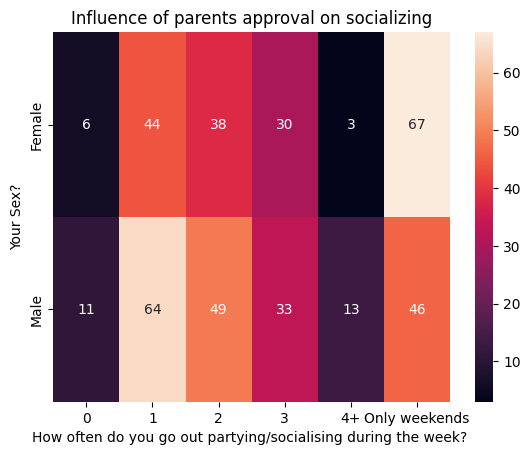

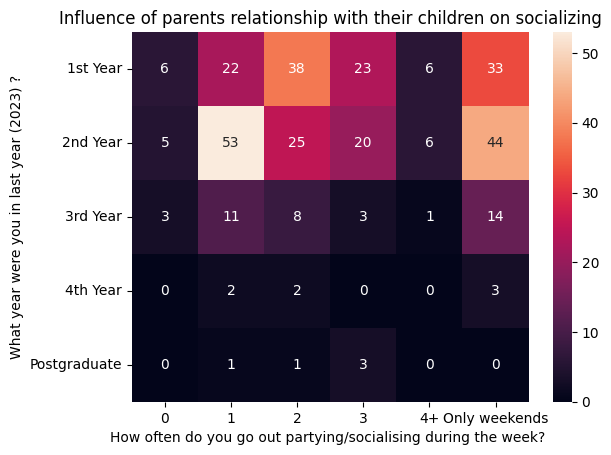

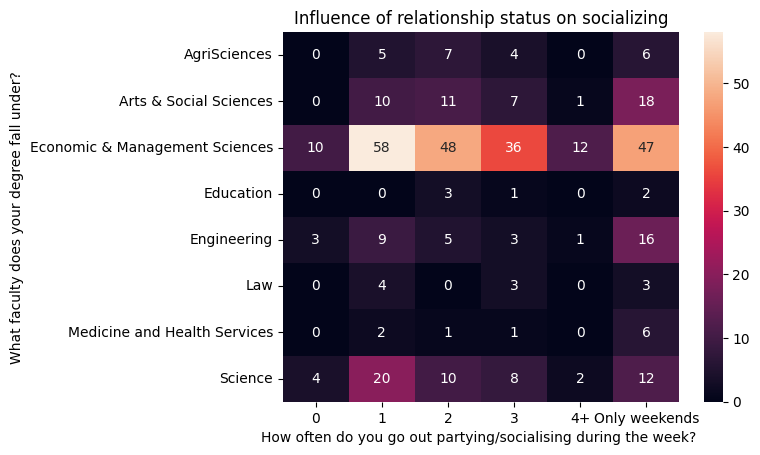

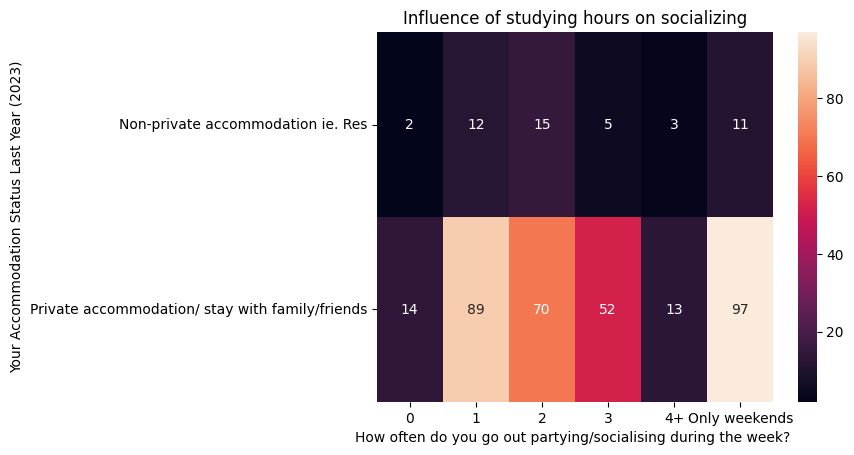

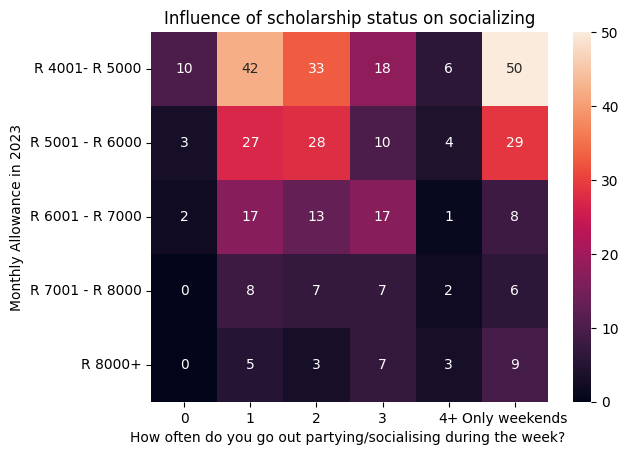

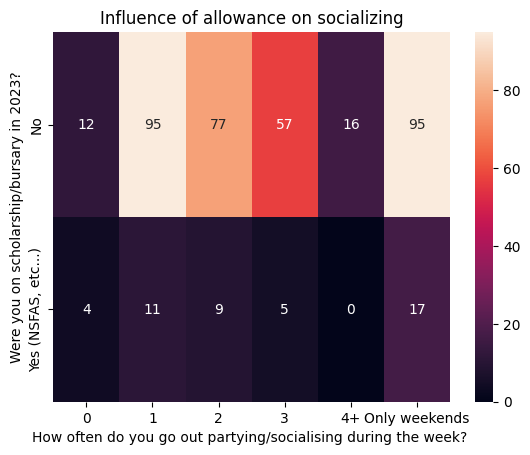

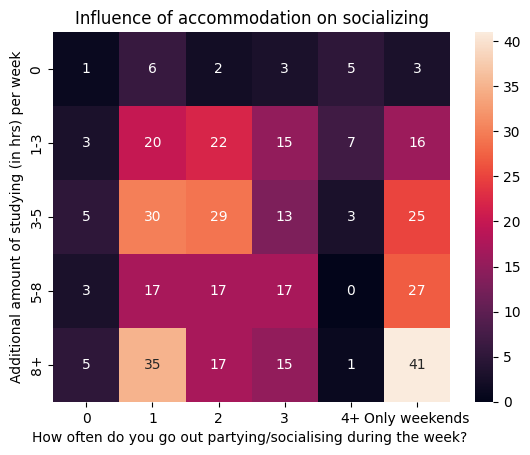

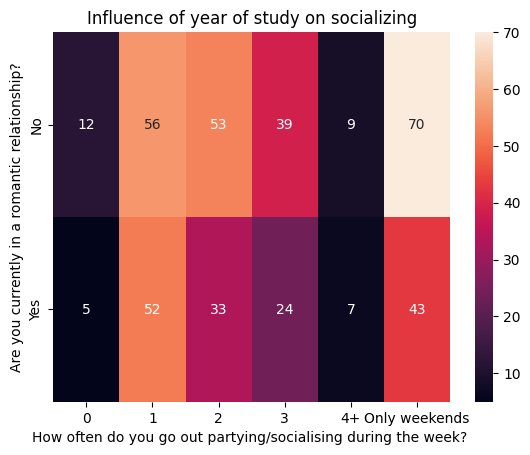

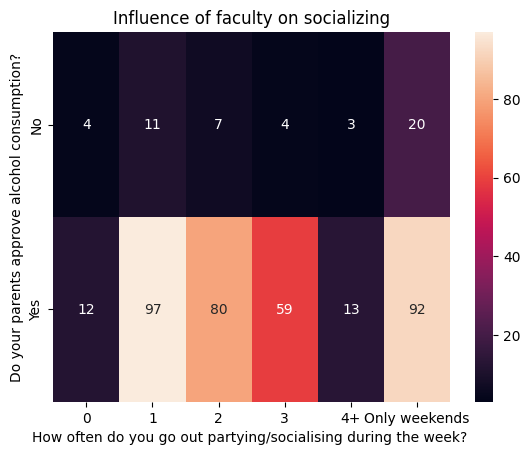

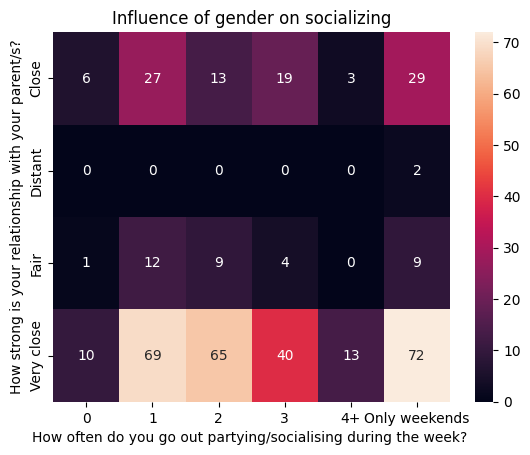

In [28]:
selected_columns = [1, 3, 4, 6, 7, 8, 9, 14, 15, 16]
initials = ['parents approval', 'parents relationship with their children',
           'relationship status', 'studying hours', 'scholarship status', 'allowance',
           'accommodation', 'year of study', 'faculty', 'gender']


for i, j in enumerate(selected_columns):    
    cross = pd.crosstab(raw_data[raw_data.columns[j]], raw_data[raw_data.columns[10]])
    sns.heatmap(cross, annot=True)
    plt.title(f'Influence of {initials[i]} on socializing')
    plt.show()

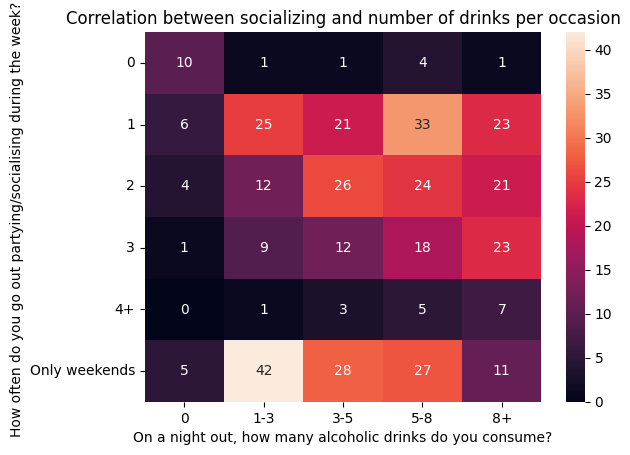

In [29]:
sns.heatmap(pd.crosstab(raw_data[raw_data.columns[10]], raw_data[raw_data.columns[11]]), annot=True)
plt.title('Correlation between socializing and number of drinks per occasion')
plt.show()

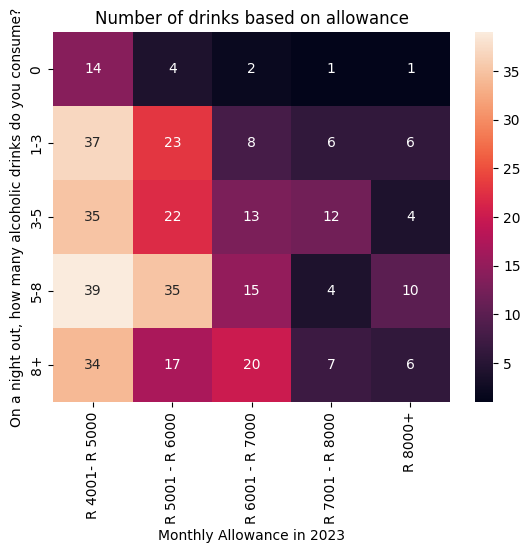

In [30]:
sns.heatmap(pd.crosstab(raw_data[raw_data.columns[11]], raw_data[raw_data.columns[7]]), annot=True)
plt.title('Number of drinks based on allowance')
plt.show()

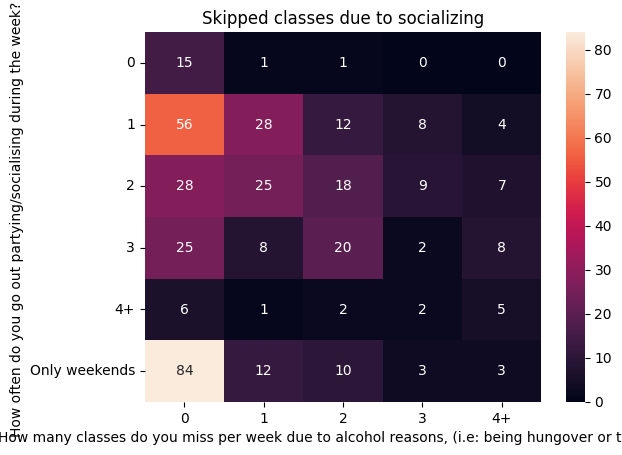

In [31]:
sns.heatmap(pd.crosstab(raw_data[raw_data.columns[10]], raw_data[raw_data.columns[12]]), annot=True)
plt.title('Skipped classes due to socializing')
plt.show()

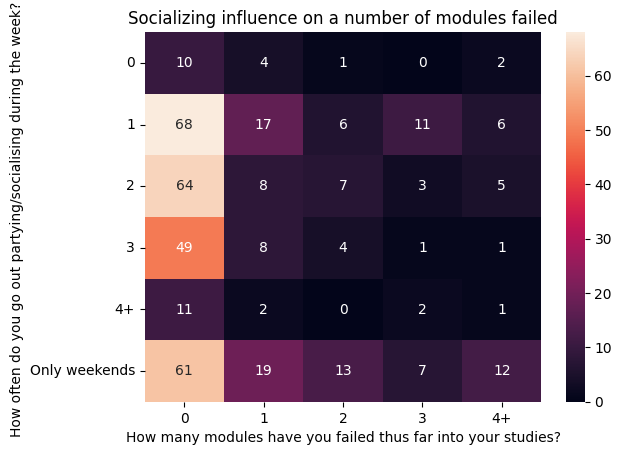

In [32]:
sns.heatmap(pd.crosstab(raw_data[raw_data.columns[10]], raw_data[raw_data.columns[13]]), annot=True)
plt.title('Socializing influence on a number of modules failed')
plt.show()

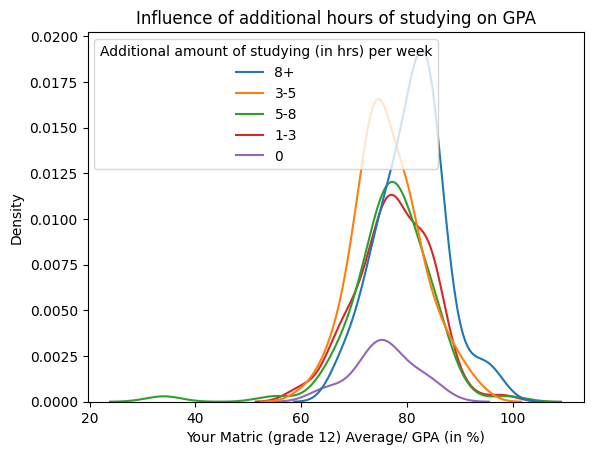

In [33]:
sns.kdeplot(raw_data, x=raw_data.columns[2], hue=raw_data.columns[9])
plt.title('Influence of additional hours of studying on GPA')
plt.show()

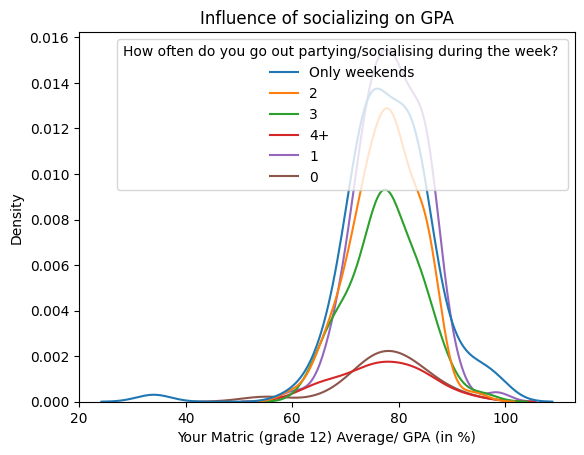

In [34]:
sns.kdeplot(raw_data, x=raw_data.columns[2], hue=raw_data.columns[10])
plt.title('Influence of socializing on GPA')
plt.show()

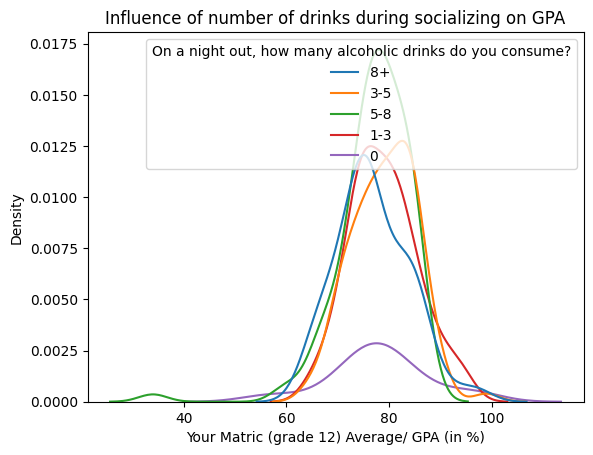

In [35]:
sns.kdeplot(raw_data, x=raw_data.columns[2], hue=raw_data.columns[11])
plt.title('Influence of number of drinks during socializing on GPA')
plt.show()

### 1.2 DAG diagram

Only few of the features are choosen to be used in our models - in our opinion the most influential ones for the student performance.
A DAG is created to illustrate the relationships between that features and the target variable (GPA).

<p align="center">
    <img src="images/DAG_.png" width=800px/ >
</p>

**Legend:**
* Colours meaning:
    * Green - ordered categorical variable,
    * Red  - binary variable,
    * Orange - target (real variable).
    
* Lines meaning:
    * Continuous line - association between block,
    * Dashed line - weak association between data.

* Framed features are used in the models.

### 1.2 Confoundings  

* Fork    

    * "Drinks consummed at the party" feature is common cause for "Studying hours" and "Missed classes".

    * "Hangouts" influences both "Drinks consummed at the party" and "Studying hours".

* Collider   

    * "Studying hours" is infulenced by "Hangouts" and "Drinks consummed at the party".

    * "Drinks consummed at the party" is influenced by "Hangouts" and "Parents alcohol approvement".

    * "GPA" is influenced by "Studying hours", "Missed classes", "Drinks consummed at the party", "Studying hours", "Hangouts". 

* Pipe

    * "Parents alcohol approvement" can influence "Drinks consummed at the party" and is transmited to "GPA".

## 2. Data preprocessing describe and reasoning
Despite using only few of the features, the whole data set is preprocessed for the sake of completeness. The following steps are taken:

* timestamp column will be dropped as it doesn't give any useful information for our purposes,
* to work with the gathered data, we’ll simplify column names for easier reference. This practice improves readability and reduces typing effort,
* rows containing NaN or missing values will be dropped. This ensures that our dataset remains clean and accurate,
* values described by two options (e.g., “yes” and “no”), will be converted  to binary format ("0" or "1"). This simplifies the representation,
* values describing incremental features (e.g., “very close,” “close,” “fair,” “distant”) will be mapped to numerical values ("3", "2", "1", "0"). Same thing will be applied to values with range format,
* the value “Only weekends” describing social activities will be changed to “1” for simplification, even though it differs from the actual value “1” (which represents drinking on weekdays, because it can have less influence on academic performance),
* faculties will be ranked subjectively from easiest to hardest for passing.

In [36]:
data = raw_data.copy()

# Rename columns and drop timestamp column
columns_names = {
    data.columns[1]: "Gender",
    data.columns[2]: "Current GPA",
    data.columns[3]: "Year",
    data.columns[4]: "Faculty",
    data.columns[5]: "Prior GPA",
    data.columns[6]: "Accommodation",
    data.columns[7]: "Allowance",
    data.columns[8]: "Scholarship",
    data.columns[9]: "Studying hours",
    data.columns[10]: "Hangouts",
    data.columns[11]: "Drinks",
    data.columns[12]: "Missed classes",
    data.columns[13]: "Failed modules",
    data.columns[14]: "Relationship",
    data.columns[15]: "Parents approvement",
    data.columns[16]: "Relationship with parents",}

data.rename(columns = columns_names, inplace=True)
data = data.drop('Timestamp', axis=1)
data.head()

,Gender,Current GPA,Year,Faculty,Prior GPA,Accommodation,Allowance,Scholarship,Studying hours,Hangouts,Drinks,Missed classes,Failed modules,Relationship,Parents approvement,Relationship with parents
0,Female,76.0,2nd Year,Arts & Social Sciences,72.0,Private accommodation/ stay with family/friends,R 4001- R 5000,No,8+,Only weekends,8+,3,0,Yes,Yes,Very close
1,Male,89.0,2nd Year,Economic & Management Sciences,75.0,Private accommodation/ stay with family/friends,R 7001 - R 8000,"Yes (NSFAS, etc...)",8+,Only weekends,3-5,4+,0,No,Yes,Very close
2,Male,76.0,1st Year,AgriSciences,55.0,Private accommodation/ stay with family/friends,R 4001- R 5000,No,3-5,2,8+,3,0,No,Yes,Very close
3,Male,89.0,2nd Year,Engineering,84.0,Private accommodation/ stay with family/friends,R 6001 - R 7000,No,3-5,3,8+,2,0,Yes,Yes,Very close
4,Female,74.0,2nd Year,Arts & Social Sciences,52.0,Private accommodation/ stay with family/friends,R 4001- R 5000,No,3-5,Only weekends,5-8,1,3,No,Yes,Fair


In [37]:
# Check data for unique values, and check if NaN or missing values are present
for column in data:
    print(data[column].unique())

['Female' 'Male' nan]
[76.   89.   74.   83.   80.   85.   75.   79.   72.   78.   87.   86.
 69.   73.   84.   99.   82.6  65.   81.   88.   70.   98.   90.   98.33
   nan 82.   77.   68.   66.   92.   91.86 71.   63.   67.   60.   94.
 95.   34.   86.4  95.5  55.   91.21 96.   64.  ]
['2nd Year' '1st Year' nan '3rd Year' '4th Year' 'Postgraduate']
['Arts & Social Sciences' 'Economic & Management Sciences' 'AgriSciences'
 'Engineering' 'Science' 'Medicine and Health Services' 'Law' 'Education'
 nan]
[72.   75.   55.   84.   52.     nan 54.   64.   76.   65.   62.   69.
 60.   74.   70.   63.   73.   57.   90.   78.   61.   89.   80.   66.
 58.   95.22 71.   53.   50.   88.   79.   56.   51.   68.   77.   65.89
 73.5  59.   67.   92.   87.6  83.   30.   81.   69.7  85.  ]
['Private accommodation/ stay with family/friends' nan
 'Non-private accommodation ie. Res']
['R 4001- R 5000' 'R 7001 - R 8000' 'R 6001 - R 7000' 'R 5001 - R 6000'
 nan 'R 8000+']
['No' 'Yes (NSFAS, etc...)' nan]
['8

In [38]:
# Drop rows with NaN (missing) values, use mapping to change values to more readable format
data.dropna(axis=0, how='any', inplace=True)


# Create mapping values for each column
gender_map = {
    'Female': 1,
    'Male': 0
}

year_map = {
    '1st Year': 0,
    '2nd Year': 1,
    '3rd Year': 2,
    '4th Year': 3,
    'Postgraduate': 4
}

faculty_map = {
    'AgriSciences': 0,
    'Arts & Social Sciences': 1,
    'Education': 2,
    'Economic & Management Sciences': 3,
    'Medicine and Health Services': 4,
    'Science': 5,
    'Engineering': 6,
    'Law': 7
}

accommodation_map = {
    'Private accommodation/ stay with family/friends': 1,
    'Non-private accommodation ie. Res': 0
}

allowance_map = {
    'R 4001- R 5000': 0,
    'R 5001 - R 6000': 1,
    'R 6001 - R 7000': 2,
    'R 7001 - R 8000': 3,
    'R 8000+': 4,
}

scholarship_map = {
    'Yes (NSFAS, etc...)' : 1,
    'No' : 0
}

study_hours_map = {
    '0': 0,
    '1-3': 1,
    '3-5': 2,
    '5-8': 3,
    '8+': 4
}

hangouts_map = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4+': 4,
    'Only weekends' : 1
}

drinks_map = {
    '0': 0,
    '1-3': 1,
    '3-5': 2,
    '5-8': 3,
    '8+': 4
}

missed_classes_map = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4+': 4
}

failed_modules_map = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4+': 4
}

relationship_map = {
    'Yes' : 1,
    'No' : 0
}

parents_approvement_map = {
    'Yes' : 1,
    'No' : 0
}

parents_relationship_map = {
    'Distant' : 0,
    'Fair' : 1,
    'Close' : 2,
    'Very close' : 3
}

maps = {
    'Gender': gender_map,
    'Year': year_map,
    'Faculty': faculty_map,
    'Accommodation': accommodation_map,
    'Allowance': allowance_map,
    'Scholarship': scholarship_map,
    'Studying hours': study_hours_map,
    'Hangouts': hangouts_map,
    'Drinks': drinks_map,
    'Missed classes': missed_classes_map,
    'Failed modules': failed_modules_map,
    'Relationship': relationship_map,
    'Parents approvement': parents_approvement_map,
    'Relationship with parents': parents_relationship_map
}

for column in data:
    if column not in ['Current GPA', 'Prior GPA']:
        data[column] = data[column].map(lambda x: maps[column].get(x, x))
        
data.head()

,Gender,Current GPA,Year,Faculty,Prior GPA,Accommodation,Allowance,Scholarship,Studying hours,Hangouts,Drinks,Missed classes,Failed modules,Relationship,Parents approvement,Relationship with parents
0,1,76.0,1,1,72.0,1,0,0,4,1,4,3,0,1,1,3
1,0,89.0,1,3,75.0,1,3,1,4,1,2,4,0,0,1,3
2,0,76.0,0,0,55.0,1,0,0,2,2,4,3,0,0,1,3
3,0,89.0,1,6,84.0,1,2,0,2,3,4,2,0,1,1,3
4,1,74.0,1,1,52.0,1,0,0,2,1,3,1,3,0,1,1


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 295 entries, 0 to 402
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Gender                     295 non-null    int64  
 1   Current GPA                295 non-null    float64
 2   Year                       295 non-null    int64  
 3   Faculty                    295 non-null    int64  
 4   Prior GPA                  295 non-null    float64
 5   Accommodation              295 non-null    int64  
 6   Allowance                  295 non-null    int64  
 7   Scholarship                295 non-null    int64  
 8   Studying hours             295 non-null    int64  
 9   Hangouts                   295 non-null    int64  
 10  Drinks                     295 non-null    int64  
 11  Missed classes             295 non-null    int64  
 12  Failed modules             295 non-null    int64  
 13  Relationship               295 non-null    int64  
 14 

In [40]:
for column in data:
    print(data[column].unique())

[1 0]
[76.   89.   74.   80.   85.   79.   72.   87.   69.   83.   78.   84.
 86.   73.   99.   82.6  65.   81.   88.   75.   98.   90.   98.33 70.
 82.   77.   68.   92.   71.   63.   67.   95.   86.4  60.   95.5  94.
 66.   64.  ]
[1 0 2 3 4]
[1 3 0 6 5 7 4 2]
[72.   75.   55.   84.   52.   54.   64.   76.   65.   62.   69.   60.
 74.   70.   63.   73.   57.   90.   78.   61.   89.   80.   66.   58.
 95.22 71.   53.   88.   79.   56.   51.   68.   50.   77.   73.5  59.
 67.   92.   87.6  83.   30.   81.   69.7  85.  ]
[1 0]
[0 3 2 1 4]
[0 1]
[4 2 1 3 0]
[1 2 3 4 0]
[4 2 3 1 0]
[3 4 2 1 0]
[0 3 4 1 2]
[1 0]
[1 0]
[3 1 2 0]


In [41]:
data.to_csv('data/survey_cleaned.csv', index=False, sep=',')

In [42]:
data = data.reset_index()

## 3. Model - differences, justification
For the purpose of this project, two statistical models are developed, each utilizing a different probability distribution for predicted student's performance.

First model take in information about studying hours, average alcohol consumption per hangout and hangouts during the week, these components are transformed and will result in a **normal distribution**.  

The second model uses the same inputs however, with the components being transformed and used in the **beta distribution**.
 

- The normal distribution is selected for the first model, because it is particularly effective in modeling phenomena where outcomes tend to cluster around a central mean. This characteristic makes this distribution suitable for predicting GPA when we assume that the GPA scores are influenced by a variety of factors that have a cumulative effect, leading to a clustering of scores around a mean value.

- On the other hand, the Beta distribution is chosen for the second model because of its flexibility and the nature of its defining parameters, α (alpha) and β (beta). These parameters allow the beta distribution to assume a wide range of shapes, including uniform, U-shaped, or J-shaped distributions, making it exceptionally versatile for modeling data. Given that the beta distribution is confined to the interval [0, 1], it is particularly useful at modeling variables with limited domain. This makes it a good choice for modeling GPA as a proportion of the total possible points a student can achieve.

### 3.1 First model - specification, description
This model is a Bayesian linear regression model implemented in Stan, aiming to predict a continuous outcome (GPA) based on three predictors: hours of study, amount of socializing activities (hangouts), and average amount of drinks consumed during them. The model uses a linear combination of these predictors, each weighted by a coefficient, to estimate the GPA. Priors for the coefficients and the shift term follow normal distributions. The model calculates the expected GPA for each observation and assesses the likelihood of the observed GPAs given these expectations.

**Inputs**:
* N - number of observations,
* gpa[N] - continuous outcome representing the GPA of each student, constrained between 0 and 100,
* hours[N] - fisrt predictor, representing the number of hours a student works, constrained between 0 and 4.
* hangouts[N] - second predictor, representing the amount of socializing activities, constrained between 0 and 4,
* drinks[N] - third predictor, representing the amount of consumed drinks at one party, constrained between 0 and 4.


**Parameters**: 
* $\theta_{1}$ - shift coeficient of the linear model,
* $\theta_{2}$  - coefficient for the hours predictor,
* $\theta_{3}$  - coefficient for the hangouts predictor,
* $\theta_{4}$  - coefficient for the drinks predictor,
* $\sigma$ - standard deviation of the GPA predictions constrained to be positive.

**Transformed parameters**:
* $\mu$[N] = $\theta_{1}$ + $\theta_{2}$ * hours[N] + $\theta_{3}$ * hangouts[N] + $\theta_{4}$ * drinks[N]

**Model**:

$$\theta_{1} \sim Normal(70, 3)$$
$$\theta_{2} \sim Normal(1.5, 0.2)$$
$$\theta_{3} \sim Normal(-0.5, 0.3)$$
$$\theta_{4} \sim Normal(-0.75, 0.3)$$
$$\sigma \sim Normal(5, 0.5)$$
$$gpa[i] \sim Normal(\mu[i], \sigma)$$


**Quantities generation**:

* predicted_gpa = fmin(normal_rng(mu[i],sigma), 100)

### 3.2 Second model  - specification, description
This model is a Bayesian hierarchical model designed to predict a scaled GPA (ranging from 0 to 1) based on three predictors: hours of study, amount of socializing activities (hangouts), and average amount of drinks consumed during them. Unlike traditional linear regression models, this model uses a beta distribution for the outcome variable, making it suitable for modeling outcomes that fall within a bounded interval (0, 1).

**Inputs**:
* N: number of observations,
* scaled_gpa[N]: conttinous outcome variable, representing scaled GPA, constrained between 0 and 1.
* hours[N] - fisrt predictor, representing the number of hours a student works, constrained between 0 and 4.
* hangouts[N] - second predictor, representing the amount of socializing activities, constrained between 0 and 4,
* drinks[N] - third predictor, representing the amount of consumed drinks at one party, constrained between 0 and 4.

**Parameters**:
* $\theta_{1}$ - factor for the shape parameter alpha.
* $\theta_{2}$ - coefficient for the hours predictor,
* $\theta_{3}$ - factor for the shape parameter beta,
* $\theta_{4}$ - coefficient for the hangouts predictor,
* $\theta_{5}$ - coefficient for the drinks predictor.

**Transformed Parameters**:
* alpha[N]: Derived parameter for the alpha shape parameter for each observation, calculated as sum of $\theta_{1}$ and $\theta_{2}$ coefficient with the hours predictor.
* beta[N]: Derived parameter for the beta shape for each observation, calculated using sum of $\theta_{3}$ and coefficients $\theta_{4}$, and $\theta_{5}$ for hangouts and drinks predictors.

**Model**:
$$\theta_{1} \sim LogNormal(3.63, 0.02)$$
$$\theta_{2} \sim LogNormal(0.4, 0.1)$$
$$\theta_{3}  \sim LogNormal(2.3, 0.1)$$
$$\theta_{4} \sim LogNormal(0.01, 0.1)$$
$$\theta_{5} \sim LogNormal(0.01, 0.1)$$
$$scaled\_gpa[i] \sim Beta(alpha[i], beta[i])$$


**Generated Quantities**:
* predicted_scaled_gpa[i] = beta_rng(alpha[i], beta[i]);

Model is particularly suited for outcomes that are proportions within a fixed interval, leveraging the flexibility of the beta distribution to accommodate various shapes of the data distribution. The hierarchical structure allows for individual-level variation through the predictors, capturing complex relationships between the predictors and the outcome.

## 4. Priors
The choice of prior distributions is based on common statistical assumptions about the nature of the given data and the factors influencing the parameter of interest.

In order to compare the results obtained from the prior, the histogram of the current GPA values is presented. Additionally, the average value was calculated along with the standard deviation.

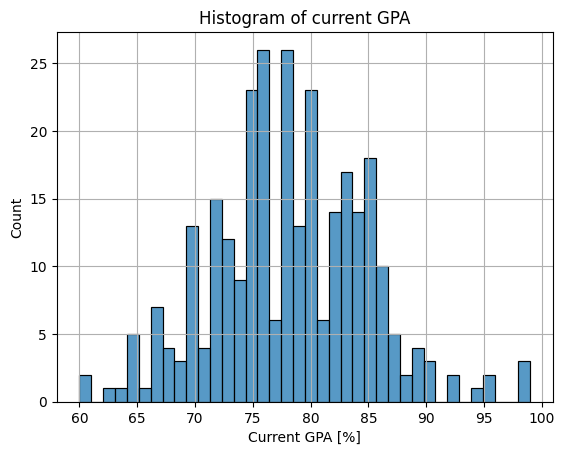

Mean value of Current GPA:  78.20959322033899
Std. value of Current GPA:  6.5774609349637565


In [43]:
sns.histplot(data['Current GPA'], bins=len(data['Current GPA'].unique()))
plt.xlabel('Current GPA [%]')
plt.title('Histogram of current GPA')
plt.grid()
plt.show()

print("Mean value of Current GPA: ", data['Current GPA'].mean())
print("Std. value of Current GPA: ", data['Current GPA'].std())

### 4.1 Prior for the first model

### TODO: do poprawy, chyba dla wspolczyników predyktorów i pozostałych parametrów (sigma i shift)

**Studying Hours**:
The normal distribution is chosen for modeling continuous variables like studying hours because it’s a common assumption that such variables tend to follow a bell-shaped distribution in a population. The values from the dataset were multiplied by a distribution centred on the coefficient theta_2, which is, so to speak, a ‘weigh’ for the input value of ‘hours’ and thus determines the impact of the hours spent on the overall predicted GPA.

**Hangouts**: 
Analogous to the previous parameter, for the "hangouts" input, a negative weight was chosen because, as is generally known, going out and spending time on meetings and entertainment instead of studying has a negative impact on the overall outcome of the study. 

**Drinks**: 
Prior for "drinks" input is chosen in the same way as "hangouts" but was defined as greater because alcohol has a bigger impact on negative outcomes than simply spending time having fun.

**Predicted GPA**: 
The predicted GPA is generated using a normal distribution where the mean is a linear combination of studying hours, hangouts, drinks and theta_1 as shift coeficient of the linear model. This factor has the greatest influence on the predicted values, having been selected on the basis of general knowledge of the average student grade, which fluctuates around 70%. A sigma value is used to ensure that the generated GPAs are densely packed around the mean, reflecting the expectation that most GPAs will be close to the average with some variation.

**Generated quantities:**

* real theta_1 = normal_rng(70, 3);
* real theta_2 = normal_rng(1.5, 0.2);
* real theta_3 = normal_rng(-0.5, 0.3);
* real theta_4 = normal_rng(-0.75, 0.3);
* real sigma = normal_rng(5, 0.5);

**Formula:** 

predicted_gpa[i] = normal_rng(theta_1 + theta_2 * hours[i] + theta_3 * hangouts[i] + theta_4 * drinks[i], sigma);

#### 4.1.1 Generating samples
The number of iterations was chosen based on the number of records in the data.


In [44]:
hours_array = np.linspace(data['Studying hours'].min(), data['Studying hours'].max(), 10)
hangouts_array = np.linspace(data['Hangouts'].min(), data['Hangouts'].max(), 10)
drinks_array = np.linspace(data['Drinks'].min(), data['Drinks'].max(), 10)

In [45]:
prior_model_1 = CmdStanModel(stan_file='src/prior_model_1.stan')

R = 295
data_simulated = {'N': 10,
                  'hours': hours_array,
                  'hangouts': hangouts_array,
                  'drinks': drinks_array
                  }  
samples_model_1 = prior_model_1.sample(data=data_simulated,
                                       iter_sampling=R,
                                       iter_warmup=1,
                                       chains=1,
                                       fixed_param=True,
                                       seed=2024,
                                       refresh=R)

23:58:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

23:58:55 - cmdstanpy - INFO - CmdStan done processing.


In [46]:
df_1 = samples_model_1.draws_pd()
df_1.head()

,chain__,iter__,draw__,lp__,accept_stat__,predicted_gpa[1],predicted_gpa[2],predicted_gpa[3],predicted_gpa[4],predicted_gpa[5],predicted_gpa[6],predicted_gpa[7],predicted_gpa[8],predicted_gpa[9],predicted_gpa[10],theta_1,theta_2,theta_3,theta_4,sigma
0,1.0,1.0,1.0,0.0,0.0,70.3889,76.9107,73.6546,78.5637,79.4029,72.4171,75.7093,75.0195,75.6495,74.9888,73.2738,1.96616,-0.704317,-0.962350,4.47234
1,1.0,2.0,2.0,0.0,0.0,63.4062,76.9482,72.4942,66.8689,61.2801,69.4913,70.3833,79.9040,70.6598,67.1642,68.1675,1.62852,-0.223507,-0.860637,5.13495
2,1.0,3.0,3.0,0.0,0.0,62.2216,88.3991,74.7620,65.1268,76.8465,66.5906,68.4551,68.4361,81.1832,81.3217,71.6632,1.61263,-0.751453,-0.761853,4.33552
3,1.0,4.0,4.0,0.0,0.0,52.9535,75.0503,64.9027,66.9818,67.8547,67.0238,73.0597,70.3958,69.5123,55.6533,66.8640,1.56050,-0.285845,-0.857026,5.32489
4,1.0,5.0,5.0,0.0,0.0,66.2736,62.7180,66.1164,72.0721,69.1389,71.4551,70.4993,70.2006,70.9310,70.3106,67.7270,1.30805,-0.194604,-0.730232,4.21608


#### 4.1.2 Prior predictive checks for parameters and measurements

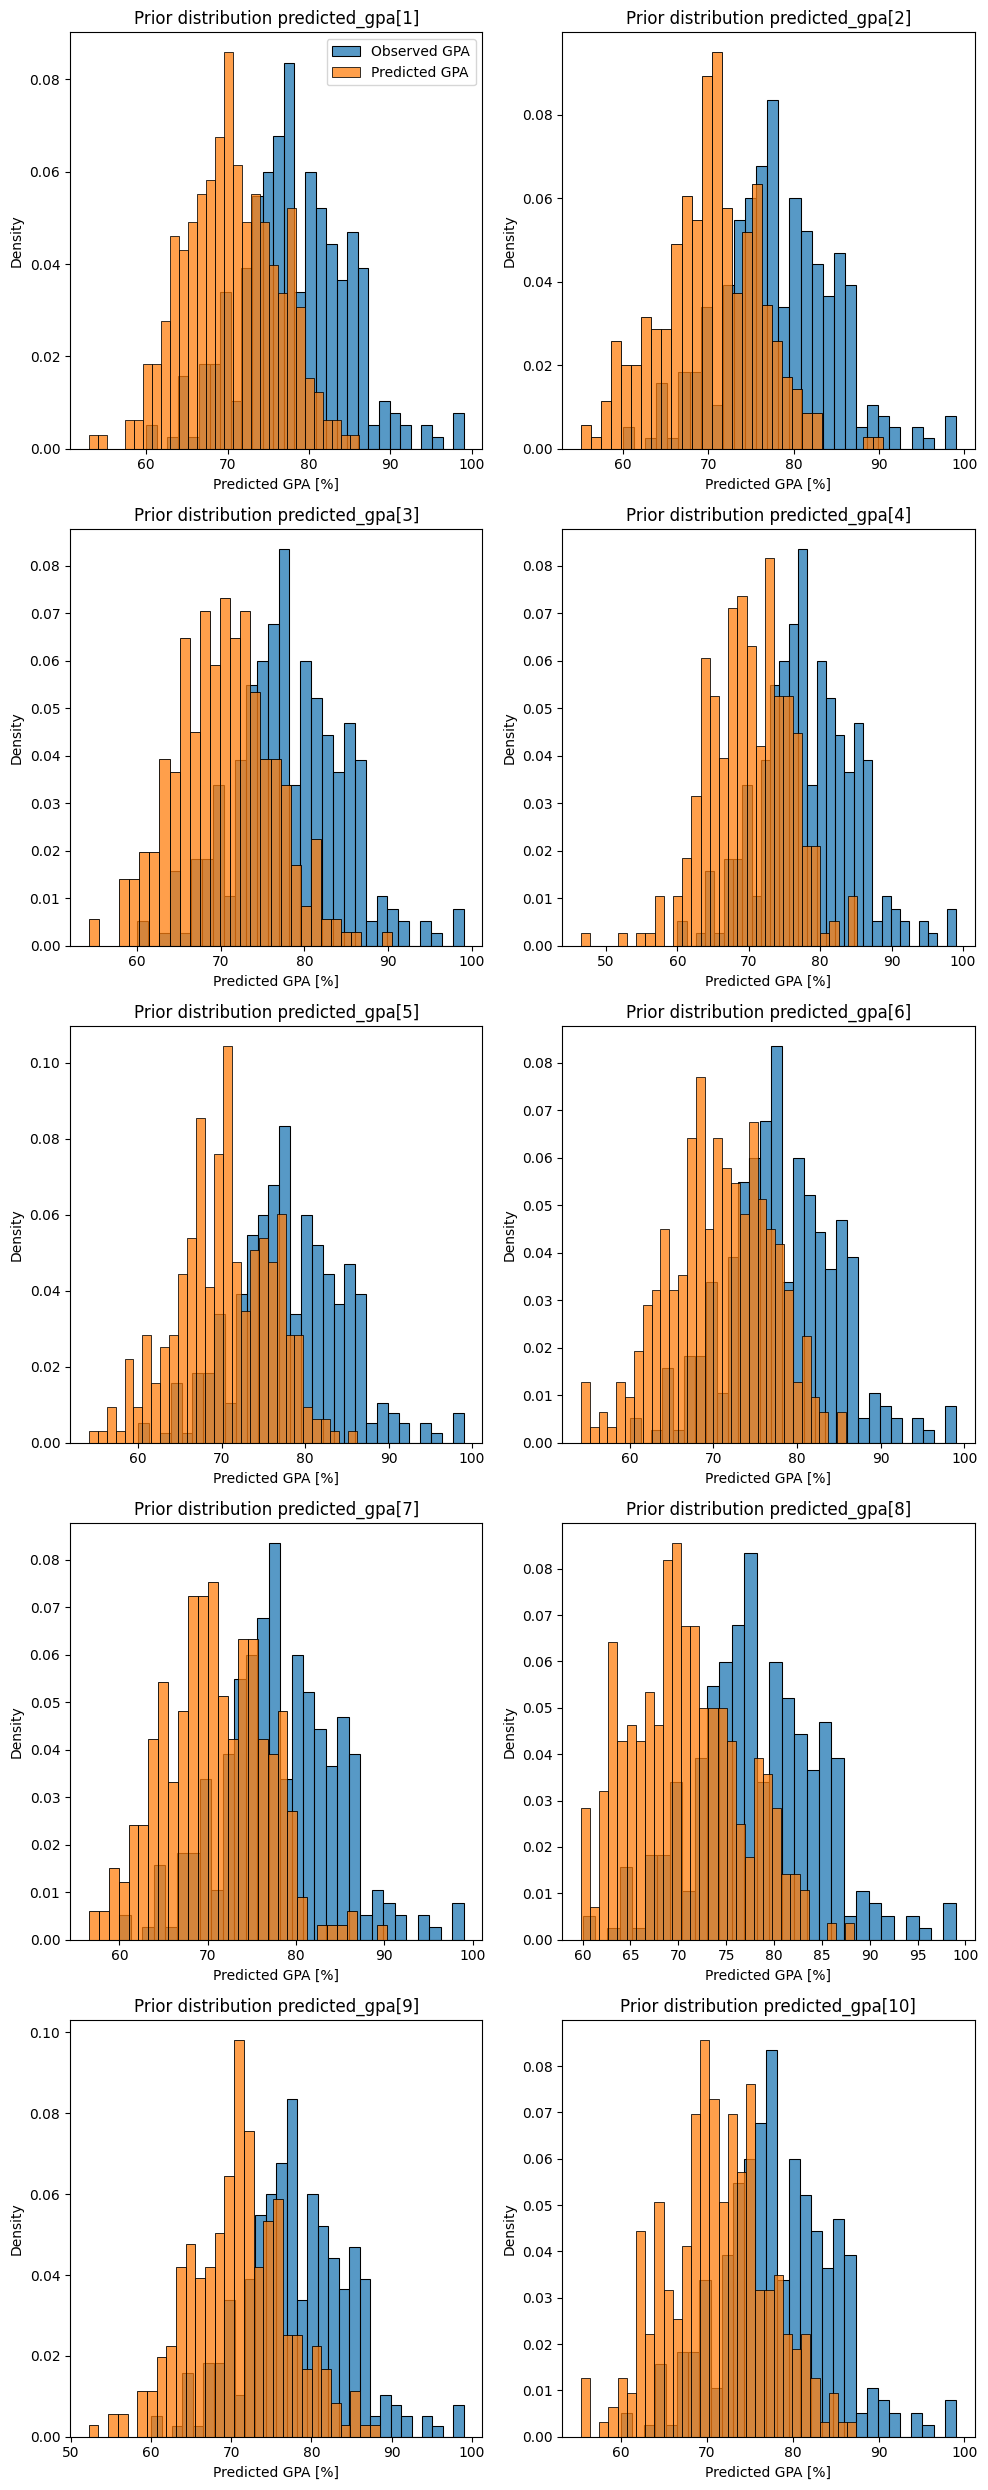

In [57]:
columns = [f'predicted_gpa[{i+1}]' for i in range(10)]

fig, axes = plt.subplots(5, 2, figsize=(10, 25))

for i, column in enumerate(columns):    
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    sns.histplot(data['Current GPA'], ax=ax, bins=30, stat='density')
    sns.histplot(df_1[column], ax=ax, bins=30, stat='density')
    
    ax.set_title(f'Prior distribution {column}')
    ax.set_xlabel('Predicted GPA [%]')
    if i == 0:
        ax.legend(['Observed GPA', 'Predicted GPA'])

plt.tight_layout()
plt.show()

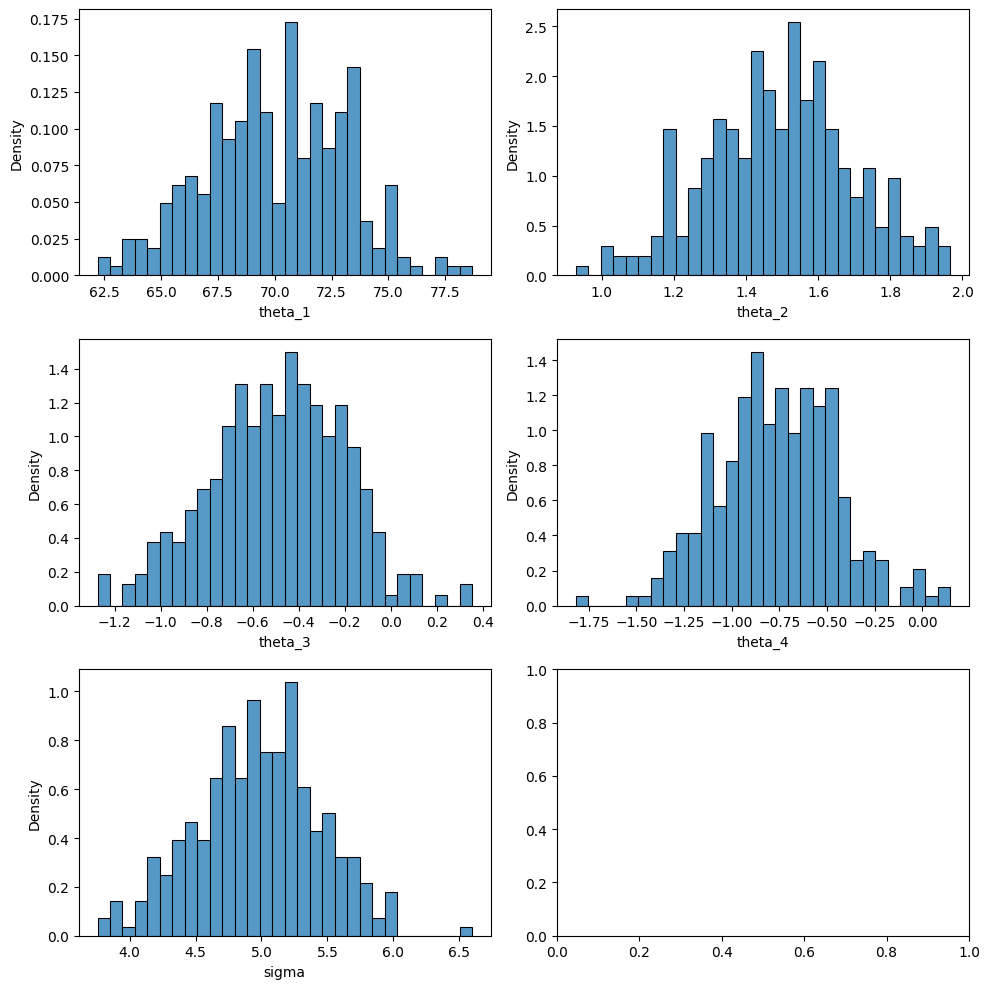

In [58]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
sns.histplot(df_1['theta_1'], ax=axes[0][0], bins=30, stat='density')
sns.histplot(df_1['theta_2'], ax=axes[0][1], bins=30, stat='density')
sns.histplot(df_1['theta_3'], ax=axes[1][0], bins=30, stat='density')
sns.histplot(df_1['theta_4'], ax=axes[1][1], bins=30, stat='density')
sns.histplot(df_1['sigma'], ax=axes[2][0], bins=30, stat='density')

plt.tight_layout()
plt.show()

#### 4.2 Prior for the second model

### TODO: do poprawy, chyba dla wspolczyników predyktorów i pozostałych parametrów (sigma i shift)

**Studying Hours**:
Same assumptions as in prior distribution for the first model, but a "weight" theta_2 was declared by lognormal distribution due to the fact that lognormal distribution is appropriate for variables that represent multiplicative effects. In many scenarios, underlying factors multiply rather than add. By using lognormal distributions, the model implicitly assumes that the effects of the predictors on the outcome (GPA) are multiplicative.
In addition, this distribution provides positive values, which prevents the distribution shape factor from becoming negative.

**Hangouts**: 
Same assumptions as in prior distribution for the first model, also distributions chenged to lognormal due to the same reasons as for "studying hours".

**Drinks**: 
Same assumptions as in prior distribution for the first model, also distributions chenged to lognormal due to the same reasons as for "studying hours".

**Predicted GPA**: 
For each observation, the model predicts the GPA using a beta distribution. The beta distribution is parameterized by two shape parameters, α (alpha) and β (beta), which in this model are calculated as linear combinations of the input variables (hours, hangouts, drinks) weighted by their respective coefficients (theta_2, theta_4, theta_5) and adjusted by theta_1 and theta_3.
Parameter values were chosen so that the final distribution oscillates, as in the first model, close to 70%.

The beta distribution naturally outputs values between 0 and 1, representing proportions. To convert these proportions to GPA scores on a 0-100 scale, the model multiplies the output of the beta distribution by 100. 

**Generated quantities:**

* array[N] real<lower=0, upper=100> predicted_gpa;

Adjust beta distribution for average 70-80% GPA
* real theta_1 = lognormal_rng(3.63, 0.02);
* real theta_3 = lognormal_rng(2.3, 0.1);

Predictors coefficients
* real theta_2 = lognormal_rng(0.4, 0.1);
* real theta_4 = lognormal_rng(0.01, 0.1);
* real theta_5 = lognormal_rng(0.01, 0.1);

**Formula:** 

predicted_gpa[i] = 100 * beta_rng(theta_1 + theta_2 * hours[i], theta_3 + theta_4 * hangouts[i] + theta_5 * drinks[i]);


#### 4.2.1 Generating samples

In [59]:
prior_model_2 = CmdStanModel(stan_file='src/prior_model_2.stan')

data_simulated = {'N': 10,
                  'hours': hours_array,
                  'hangouts': hangouts_array,
                  'drinks': drinks_array
                  }  

samples_model_2 = prior_model_2.sample(data=data_simulated,
                                       iter_sampling=R,
                                       iter_warmup=1,
                                       chains=1,
                                       fixed_param=True,
                                       seed=2024,
                                       refresh=R)

00:01:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

00:01:35 - cmdstanpy - INFO - CmdStan done processing.


In [60]:
df_2 = samples_model_2.draws_pd()
df_2.head()

,chain__,iter__,draw__,lp__,accept_stat__,predicted_gpa[1],predicted_gpa[2],predicted_gpa[3],predicted_gpa[4],predicted_gpa[5],predicted_gpa[6],predicted_gpa[7],predicted_gpa[8],predicted_gpa[9],predicted_gpa[10],theta_1,theta_3,theta_2,theta_4,theta_5
0,1.0,1.0,1.0,0.0,0.0,83.7146,75.2399,73.4775,77.1464,77.5537,72.9840,62.8250,68.1164,68.2142,65.9879,38.5450,12.59220,1.39361,0.941027,0.908889
1,1.0,2.0,2.0,0.0,0.0,85.5164,70.8254,75.7923,69.8969,77.8966,70.3799,79.8984,70.9203,61.7849,60.0279,38.0273,10.28200,1.55843,1.035540,1.030130
2,1.0,3.0,3.0,0.0,0.0,83.0179,79.5921,85.4603,73.9723,84.2978,82.5103,78.1445,79.4541,69.6388,75.6991,38.7095,9.88808,1.58973,0.969455,1.102760
3,1.0,4.0,4.0,0.0,0.0,79.4828,84.4523,77.8680,78.6734,69.6432,79.4619,74.2302,77.3841,68.4013,66.3606,37.6056,9.93576,1.69663,1.100630,0.890290
4,1.0,5.0,5.0,0.0,0.0,74.1483,83.7839,72.8854,68.4127,75.9239,75.8833,78.6432,77.5228,85.4414,80.8814,37.2906,10.22500,1.24729,1.239810,1.000120


#### 4.2.2 Prior predictive checks for parameters and measurements

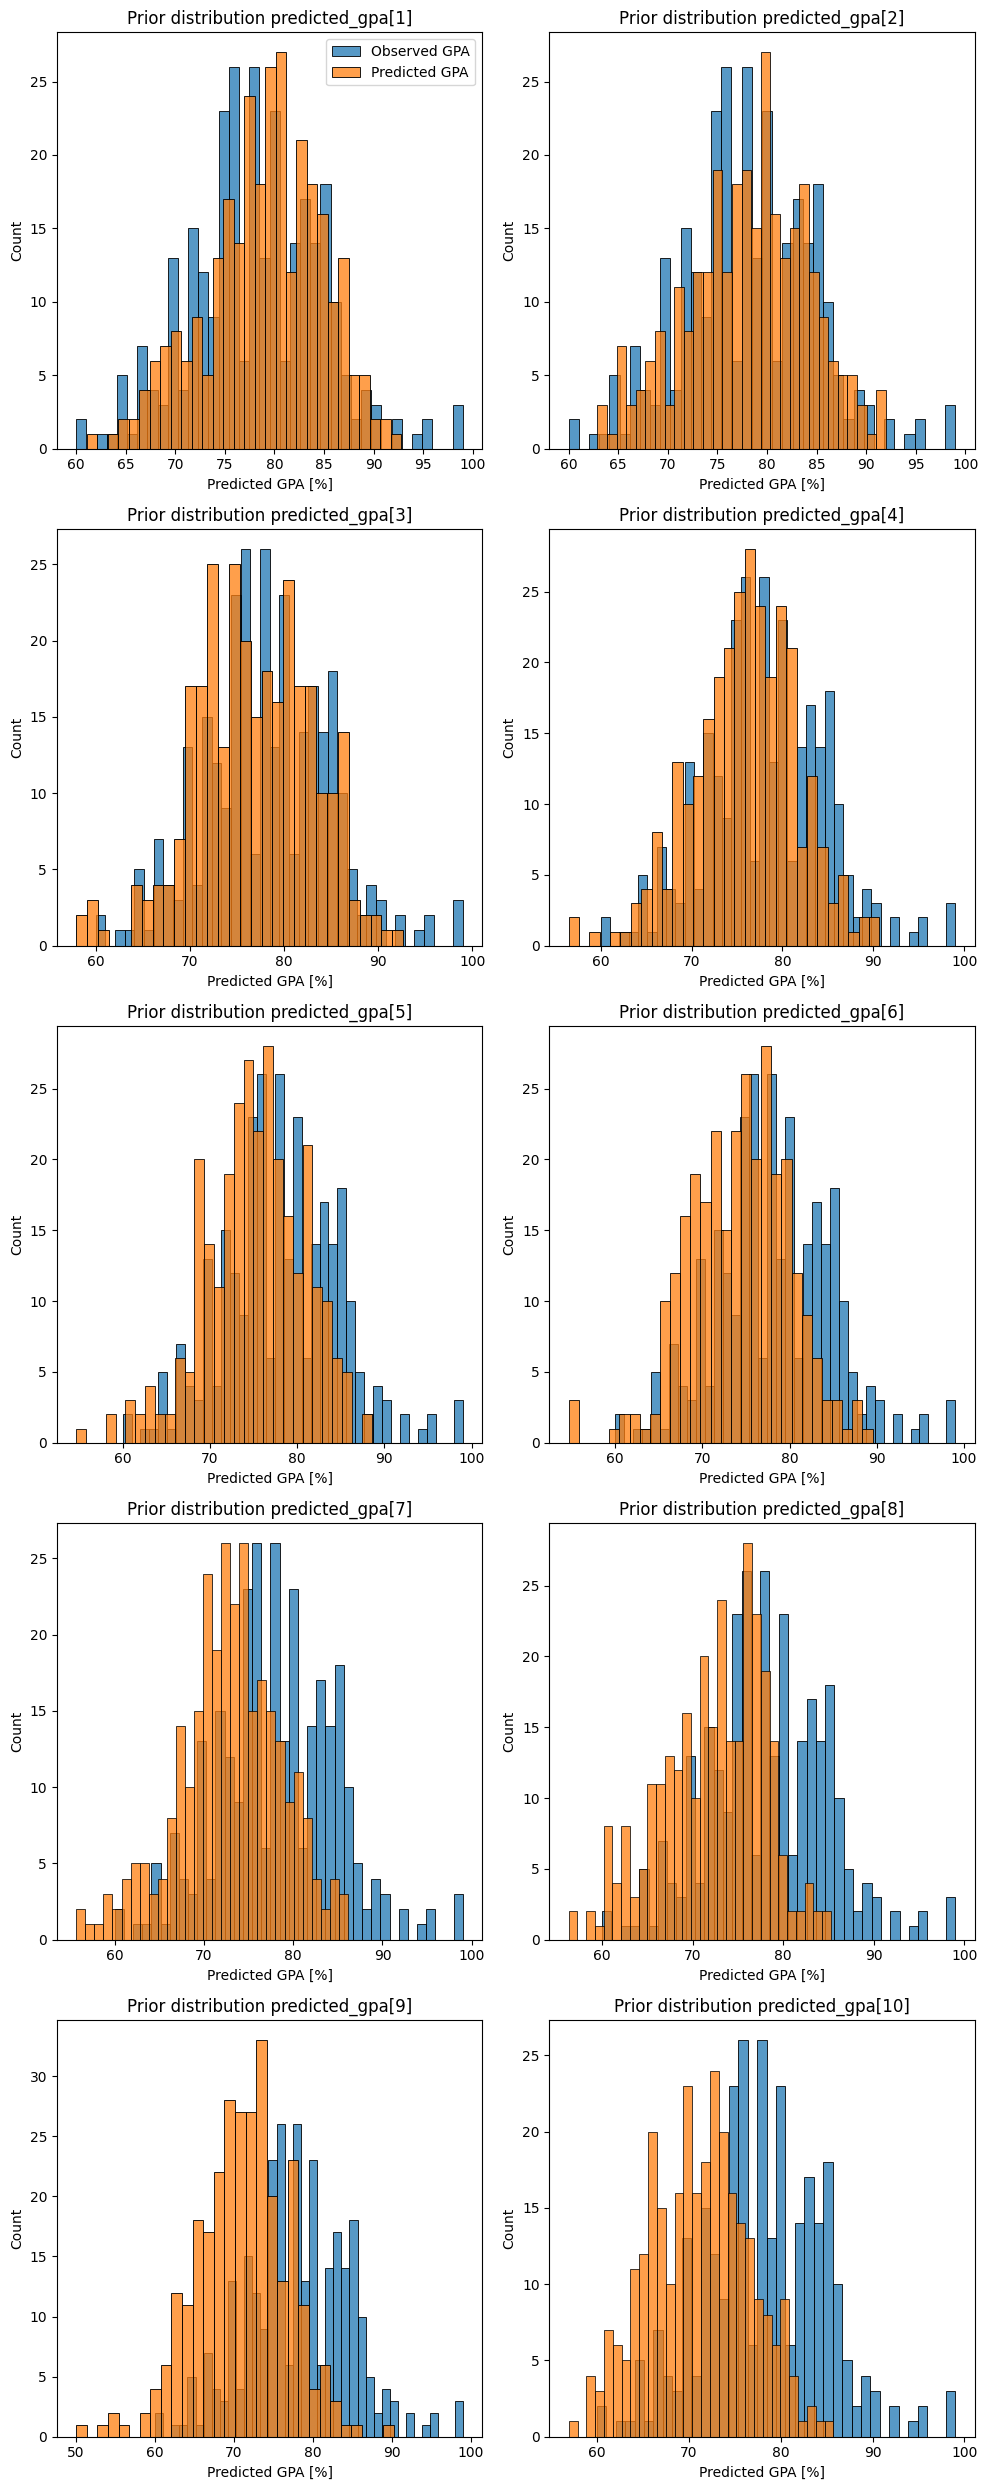

In [61]:
columns = [f'predicted_gpa[{i+1}]' for i in range(10)]

fig, axes = plt.subplots(5, 2, figsize=(10, 25))

for i, column in enumerate(columns):    
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    sns.histplot(data['Current GPA'], ax=ax, bins=len(data['Current GPA'].unique()))
    sns.histplot(df_2[column], ax=ax, bins=30)
    
    ax.set_title(f'Prior distribution {column}')
    ax.set_xlabel('Predicted GPA [%]')
    if i == 0:
        ax.legend(['Observed GPA', 'Predicted GPA'])

plt.tight_layout()
plt.show()

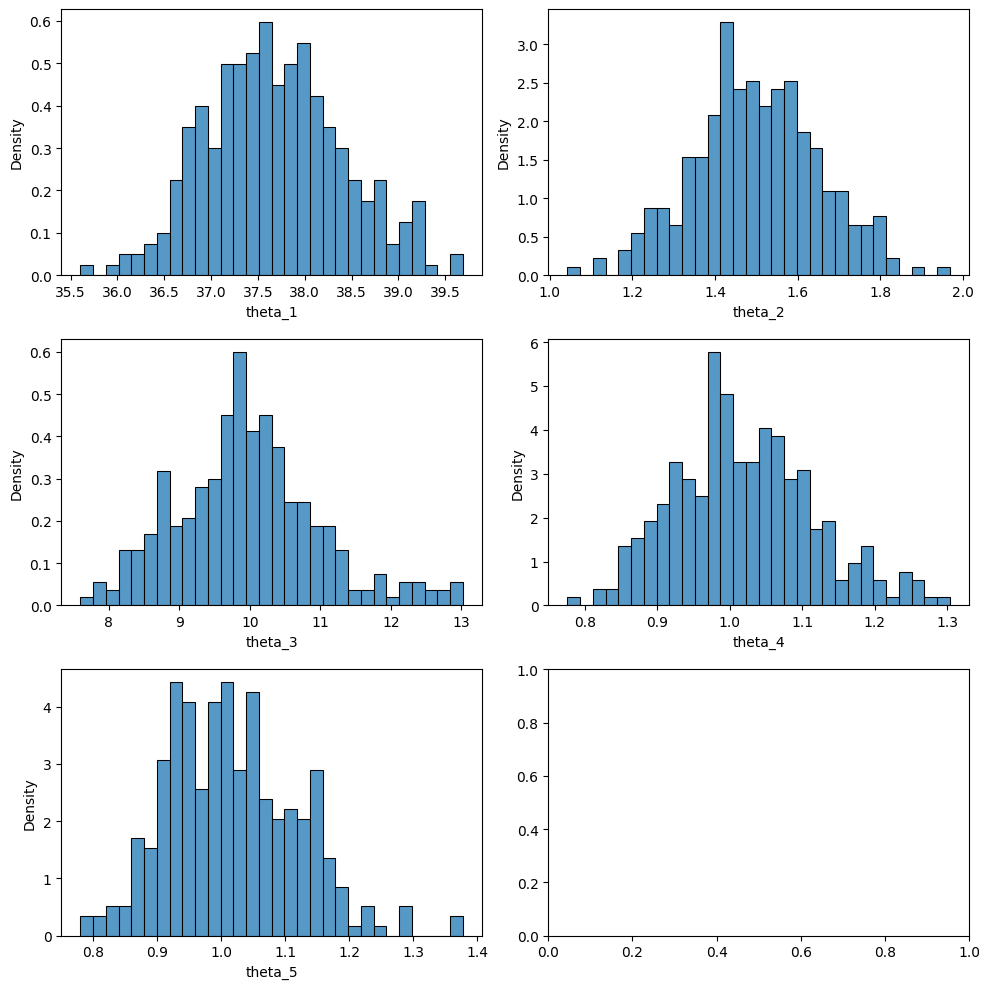

In [62]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
sns.histplot(df_2['theta_1'], ax=axes[0][0], bins=30, stat='density')
sns.histplot(df_2['theta_2'], ax=axes[0][1], bins=30, stat='density')
sns.histplot(df_2['theta_3'], ax=axes[1][0], bins=30, stat='density')
sns.histplot(df_2['theta_4'], ax=axes[1][1], bins=30, stat='density')
sns.histplot(df_2['theta_5'], ax=axes[2][0], bins=30, stat='density')

plt.tight_layout()
plt.show()

## 5. Posterior analysis for the first model

### 5.1 Issues with the sampling for first model

For the first posterior model, we encountered two important limitations during sampling. Namely, in extreme cases, the sigma predictor values, were negative, which caused errors and prevented subsequent model comparison. The second important change was that we had to introduce an upper limit for the generated GPA values, as values above 100% also appeared in extreme cases. The problem was solved using the fmin function rather than changing the predictor values, as this gave a better overall prediction.

In [58]:
np.random.seed(2024)

### TODO: warning z scaling parameter

In [63]:
posterior_model_1 = CmdStanModel(stan_file='src/posterior_model_1.stan')

indexes = list(np.random.choice(range(295), 10, replace=False))
data_fit = {'N': 10, 
            'hours': (data['Studying hours'][indexes]),
            'hangouts': (data['Hangouts'][indexes]),
            'drinks': (data['Drinks'][indexes]),
            'gpa': data['Current GPA'][indexes]}

model_fit_1 = posterior_model_1.sample(data=data_fit, seed=2024)

df_3 = model_fit_1.draws_pd()
df_3.head()

00:02:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

00:02:23 - cmdstanpy - INFO - CmdStan done processing.
00:02:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'posterior_model_1.stan', line 34, column 8 to column 38)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'posterior_model_1.stan', line 34, column 8 to column 38)
Consider re-running with show_console=True if the above output is unclear!


,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,...,log_likelihood[1],log_likelihood[2],log_likelihood[3],log_likelihood[4],log_likelihood[5],log_likelihood[6],log_likelihood[7],log_likelihood[8],log_likelihood[9],log_likelihood[10]
0,1.0,1.0,1.0,-24.5217,0.909270,0.719709,2.0,3.0,0.0,26.9625,...,-2.51870,-5.59119,-3.59454,-3.42658,-4.06543,-2.53032,-3.75205,-2.54366,-2.54434,-2.84252
1,1.0,2.0,2.0,-27.5625,0.797808,0.719709,2.0,3.0,0.0,28.6665,...,-2.51217,-5.52188,-3.66135,-3.31194,-4.29423,-2.61133,-3.34454,-2.60889,-2.52121,-2.64374
2,1.0,3.0,3.0,-24.7898,0.999083,0.719709,2.0,3.0,0.0,27.9063,...,-2.49472,-5.93887,-3.47410,-3.21301,-4.48298,-2.51453,-3.30510,-2.52840,-2.57324,-2.83378
3,1.0,4.0,4.0,-24.7325,0.821859,0.719709,3.0,7.0,0.0,30.3548,...,-2.50543,-6.00062,-3.43073,-3.21463,-4.47803,-2.49878,-3.20024,-2.51805,-2.65692,-3.01277
4,1.0,5.0,5.0,-26.6437,0.791910,0.719709,3.0,7.0,0.0,28.3816,...,-2.95790,-7.02232,-2.73995,-2.69160,-5.51421,-2.76727,-2.73480,-2.79117,-3.15824,-3.62266


### 5.2 Posterior predictive checks for parameters and measurements

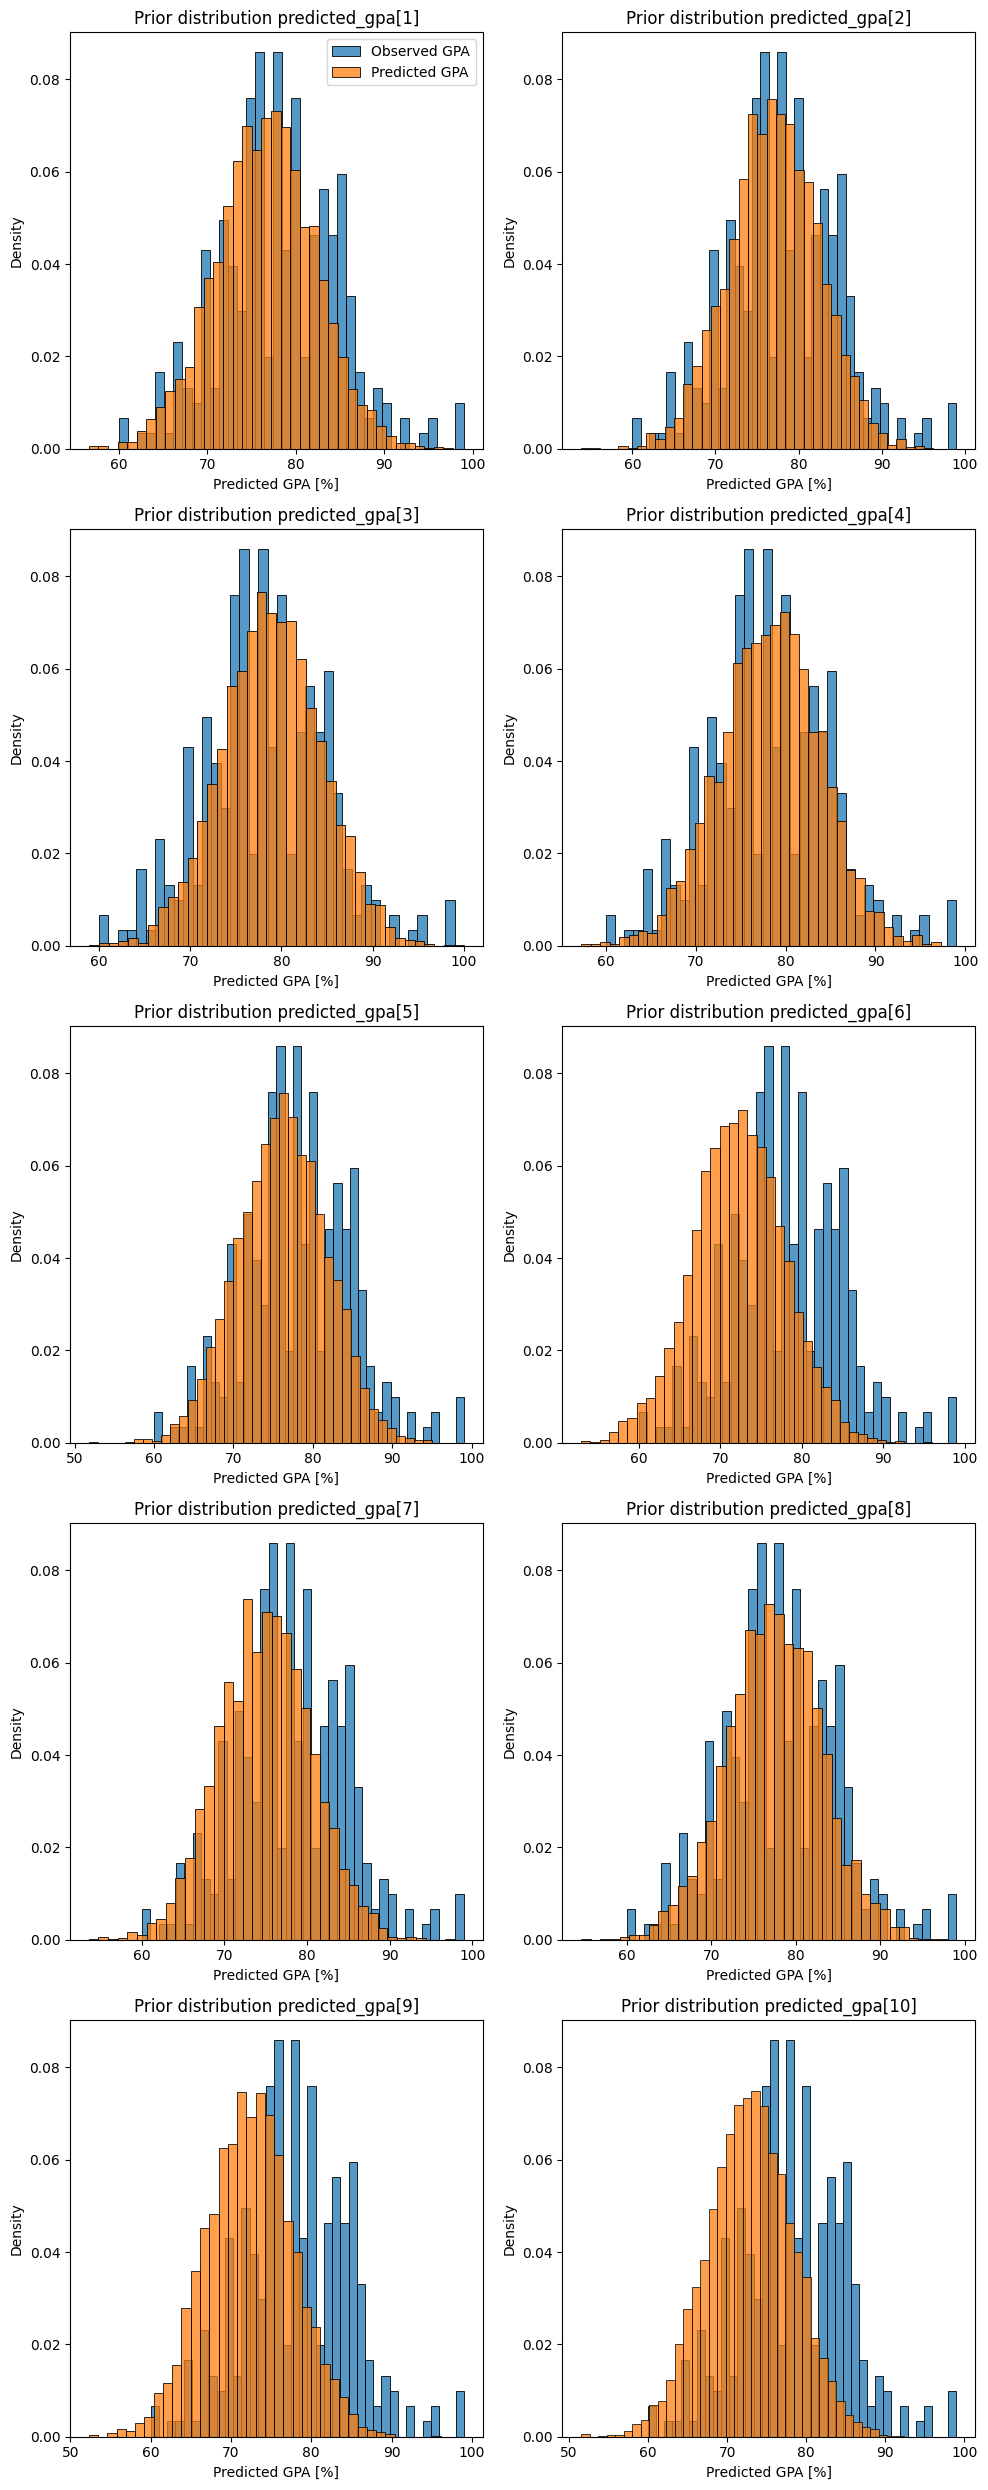

In [64]:
columns = [f'predicted_gpa[{i+1}]' for i in range(10)]

fig, axes = plt.subplots(5, 2, figsize=(10, 25))

for i, column in enumerate(columns):    
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    sns.histplot(data['Current GPA'], ax=ax, bins=len(data['Current GPA'].unique()), stat='density')
    sns.histplot(df_3[column], ax=ax, bins=len(data['Current GPA'].unique()), stat='density')
    
    ax.set_title(f'Prior distribution {column}')
    ax.set_xlabel('Predicted GPA [%]')
    if i == 0:
        ax.legend(['Observed GPA', 'Predicted GPA'])

plt.tight_layout()
plt.show()

### 5.3 Parameter marginal disrtibutions for first model

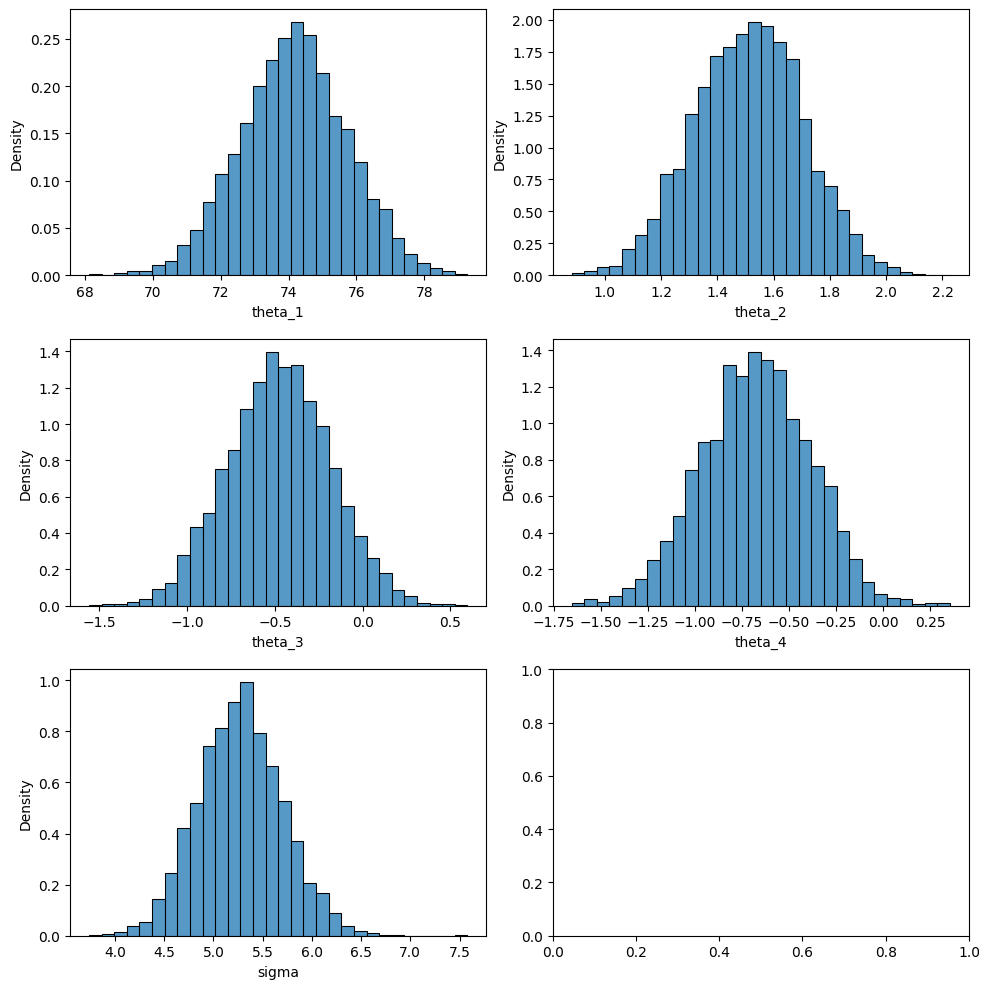

In [66]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
sns.histplot(df_3['theta_1'], ax=axes[0][0], bins=30, stat='density')
sns.histplot(df_3['theta_2'], ax=axes[0][1], bins=30, stat='density')
sns.histplot(df_3['theta_3'], ax=axes[1][0], bins=30, stat='density')
sns.histplot(df_3['theta_4'], ax=axes[1][1], bins=30, stat='density')
sns.histplot(df_3['sigma'], ax=axes[2][0], bins=30, stat='density')

plt.tight_layout()
plt.show()

## 6. Posterior analysis for the second model

### 6.1 Issues with the sampling for second model

For the second model, when sampling, the biggest problem was the appropriate transformation of the predictors passed as shape factors in the beta distribution. After a longer analysis, the relationship and the impact of adding appropriate predictors to the given shape coefficients were found and the final version of the model was obtained on this basis.

### TODO: warningi z log_prob

In [67]:
posterior_model_2 = CmdStanModel(stan_file='src/posterior_model_2.stan')

scaled_gpa = data['Current GPA'][indexes] / 100

data_fit = {'N': 10, 
            'hours': (data['Studying hours'][indexes]),
            'hangouts': (data['Hangouts'][indexes]),
            'drinks': data['Drinks'][indexes],
            'scaled_gpa': scaled_gpa}

model_fit_2 = posterior_model_2.sample(data=data_fit, seed=2024)

df_4 = model_fit_2.draws_pd()
df_4.head()

00:03:46 - cmdstanpy - INFO - compiling stan file /home/daniel/Documents/studies/data_analytics/project/src/posterior_model_2.stan to exe file /home/daniel/Documents/studies/data_analytics/project/src/posterior_model_2
00:04:08 - cmdstanpy - INFO - compiled model executable: /home/daniel/Documents/studies/data_analytics/project/src/posterior_model_2
00:04:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

00:04:08 - cmdstanpy - INFO - CmdStan done processing.
00:04:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Random variable is -0.321073, but must be nonnegative! (in 'posterior_model_2.stan', line 31, column 4 to column 35)
	Exception: posterior_model_2_model_namespace::log_prob: alpha_param[1] is -3.25824, but must be greater than or equal to 0.000000 (in 'posterior_model_2.stan', line 18, column 4 to column 39)
	Exception: posterior_model_2_model_namespace::log_prob: alpha_param[1] is -4.68717, but must be greater than or equal to 0.000000 (in 'posterior_model_2.stan', line 18, column 4 to column 39)
	Exception: posterior_model_2_model_namespace::log_prob: alpha_param[1] is -1.35255, but must be greater than or equal to 0.000000 (in 'posterior_model_2.stan', line 18, column 4 to column 39)
	Exception: posterior_model_2_model_namespace::log_prob: beta_param[1] is -0.865331, but must be greater than or equal to 0.000000 (in 'posterior_model_2.st

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,...,log_likelihood[1],log_likelihood[2],log_likelihood[3],log_likelihood[4],log_likelihood[5],log_likelihood[6],log_likelihood[7],log_likelihood[8],log_likelihood[9],log_likelihood[10]
0,1.0,1.0,1.0,-2.677840,0.853944,0.568237,3.0,7.0,0.0,7.02211,...,1.98713,-0.122023,0.717797,1.03174,1.090370,1.39301,1.14794,1.65546,1.75913,1.88460
1,1.0,2.0,2.0,-1.857380,0.978238,0.568237,3.0,7.0,0.0,4.73914,...,1.63965,-2.027410,1.479460,1.70667,-0.374754,1.77551,1.78044,1.92347,1.87396,1.86354
2,1.0,3.0,3.0,-0.095961,1.000000,0.568237,2.0,3.0,0.0,2.09827,...,1.75778,-1.539980,1.339300,1.60090,-0.012610,1.71624,1.69991,1.88961,1.87357,1.88924
3,1.0,4.0,4.0,-4.432570,0.815100,0.568237,2.0,3.0,0.0,5.44060,...,1.84930,-0.860496,0.979280,1.38759,0.357796,1.58982,1.61332,1.75853,1.84566,1.89887
4,1.0,5.0,5.0,-4.856080,0.868595,0.568237,3.0,7.0,0.0,10.28760,...,1.78340,-0.923468,1.147910,1.46698,0.341800,1.60507,1.64588,1.79772,1.83217,1.88131


### 6.2 Posterior predictive checks for parameters and measurements

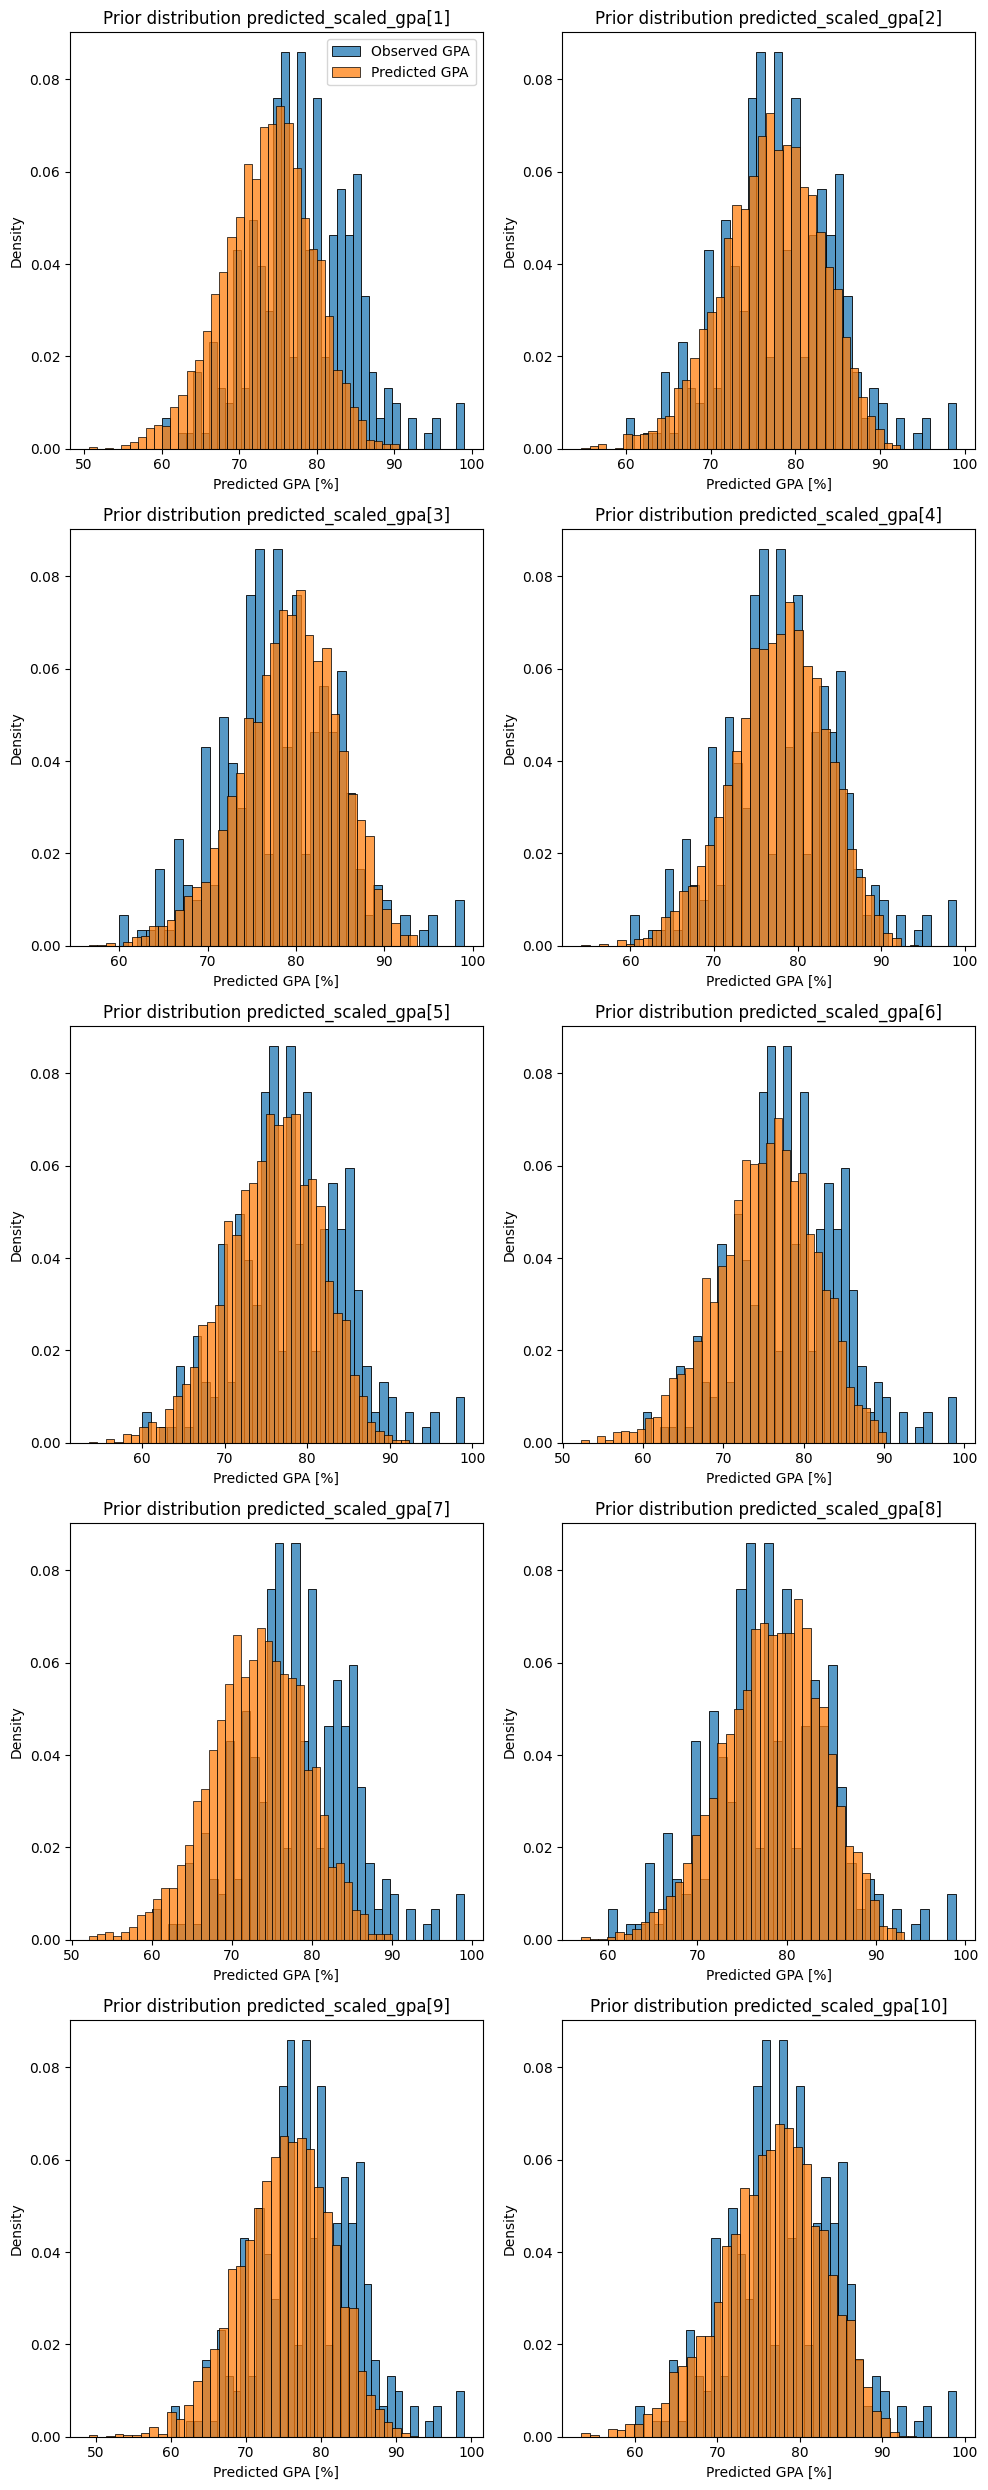

In [68]:
columns = [f'predicted_scaled_gpa[{i+1}]' for i in range(10)]

fig, axes = plt.subplots(5, 2, figsize=(10, 25))

for i, column in enumerate(columns):    
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    sns.histplot(data['Current GPA'], ax=ax, bins=len(data['Current GPA'].unique()), stat='density')
    sns.histplot(df_4[column] * 100, ax=ax, bins=len(data['Current GPA'].unique()), stat='density')
    
    ax.set_title(f'Prior distribution {column}')
    ax.set_xlabel('Predicted GPA [%]')
    if i == 0:
        ax.legend(['Observed GPA', 'Predicted GPA'])

plt.tight_layout()
plt.show()

### 6.3 Parameter marginal disrtibutions for second model

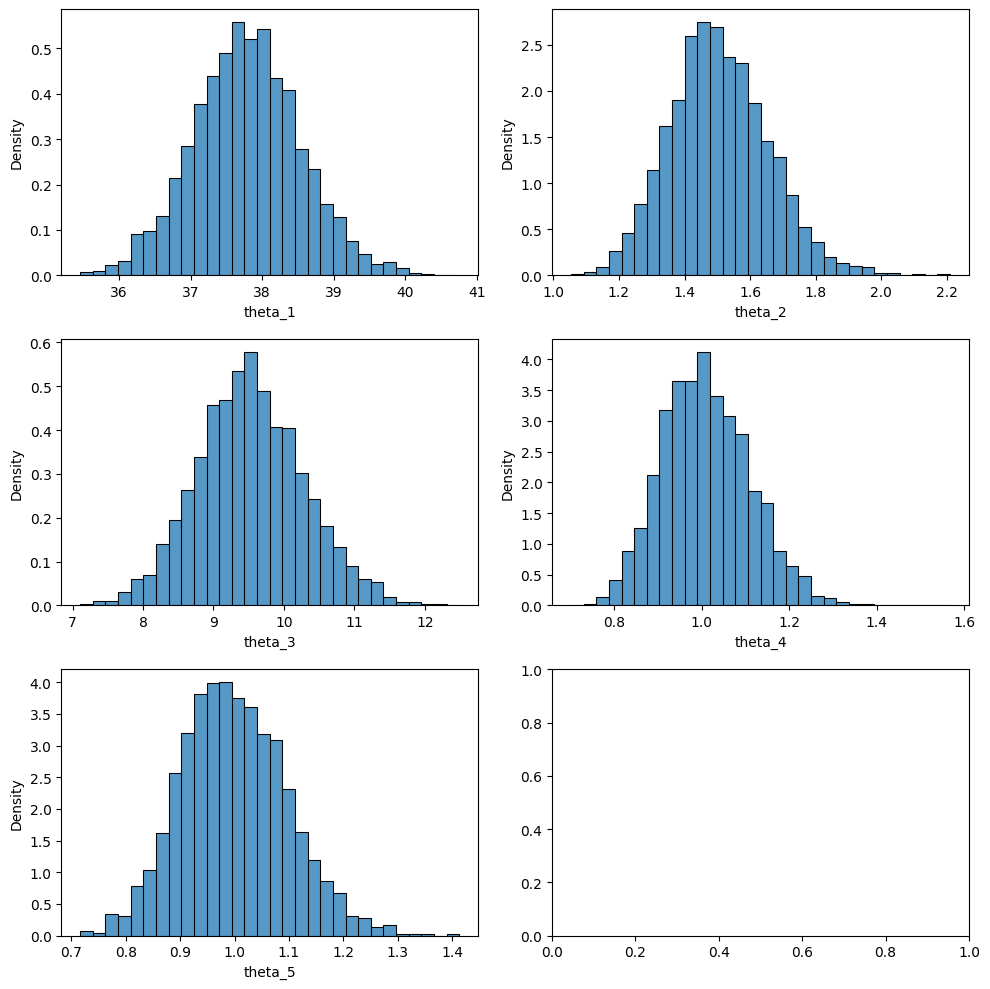

In [69]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
sns.histplot(df_4['theta_1'], ax=axes[0][0], bins=30, stat='density')
sns.histplot(df_4['theta_2'], ax=axes[0][1], bins=30, stat='density')
sns.histplot(df_4['theta_3'], ax=axes[1][0], bins=30, stat='density')
sns.histplot(df_4['theta_4'], ax=axes[1][1], bins=30, stat='density')
sns.histplot(df_4['theta_5'], ax=axes[2][0], bins=30, stat='density')

plt.tight_layout()
plt.show()

## 7. Model comparison
Description

In [71]:
fit1_az = az.from_cmdstanpy(posterior=model_fit_1,
                            log_likelihood='log_likelihood',
                            posterior_predictive='predicted_gpa',
                            observed_data={'kid_value': data["Current GPA"]})

fit2_az = az.from_cmdstanpy(posterior=model_fit_2,
                            log_likelihood='log_likelihood',
                            posterior_predictive='predicted_scaled_gpa',
                            observed_data={'kid_value': data["Current GPA"] / 100})

In [72]:
fit1_az

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [73]:
fit2_az

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [74]:
print(az.waic(fit1_az, pointwise=True))
print(az.waic(fit2_az, pointwise=True))

Computed from 4000 posterior samples and 10 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -34.38     3.33
p_waic        1.43        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 10 observations log-likelihood matrix.

          Estimate       SE
elpd_waic    12.00     3.19
p_waic        0.70        -


/home/daniel/.local/lib/python3.12/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [75]:
print(az.loo(fit1_az, pointwise=True))
print(az.loo(fit2_az, pointwise=True))

Computed from 4000 posterior samples and 10 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -34.39     3.34
p_loo        1.45        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       10  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Computed from 4000 posterior samples and 10 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    11.99     3.19
p_loo        0.71        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       10  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [76]:
waic_comparison = az.compare({"model_normal_dist": fit1_az, "model_beta_dist": fit2_az}, ic="waic", scale="deviance")
loo_comparison = az.compare({"model_normal_dist": fit1_az, "model_beta_dist": fit2_az}, ic="loo", scale="deviance")

/home/daniel/.local/lib/python3.12/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


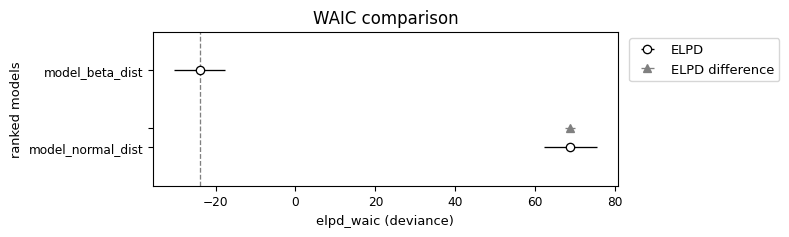

In [77]:
az.plot_compare(waic_comparison)
plt.title("WAIC comparison")
plt.show()

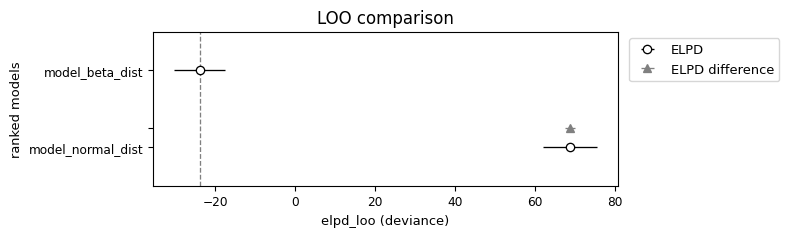

In [78]:
az.plot_compare(loo_comparison)
plt.title("LOO comparison")
plt.show()

### 8. Summary
Description